# CASE 1: **Hemonic oscillator potential**

### 1. Inizialization

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann as kB
from numpy.random import randn as gauss
from numpy.random import rand as uniform

case_study = '1D_harmonic'

### 2. Generate Trajectories


Here it's defined the function that simulates the motion of the Brownian particle in the force field. Particularly, in this case of study, we consider a Brownian particle in a double well trap. The trajectory of the particle depends on two target parameters: the equilibrium distance L and the potential energy barrier height H.

Comments:

1. The function that simulates the trajectories is *simulate_trajectory*.
2. Lambda functions scale_inputs, rescale_inputs, scale_targets, and rescale_targets must also be defined. For the best performance of the learning, the rescaling of both the inputs and targets should lead to values of order 1.

In [2]:
## define parameters
normal_values = False

In [3]:
if normal_values == True:
    
    ### follows the parameters used in DeepCalib
    
    ### Physical parameters 
    R = 1e-7                                # Radius of the Brownian particle [m]
    eta = 0.001                             # Viscosity of the medium [kg m^-1 s^-1]
    T = 300                                 # Temperature [K]
    k0 = 10                                 # Reference stiffness [fN \mu m ^-1]
    gamma0 = 6 * np.pi * eta * R            # Reference friction coefficient [kg s^-1]

    ### Simulation parameters
    N = 1000                   # Number of samples of the trajectory
    Dt = 1e-2                  # Timestep 
    oversampling = 5           # Simulation oversampling
    offset = 1000              # Number of equilibration timesteps
    batch_size = 32            # Number of trajectories

    ### Define functions to scale and rescale inputs
    scale_inputs = lambda x: x * 1e+6                    # Scales input trajectory to order 1
    rescale_inputs = lambda scaled_x: scaled_x * 1e-6    # Rescales input trajectory to physical units

    ### Define function to scale and rescale targets
    scale_targets = lambda k: np.log(k / k0)                               # Scales targets to order 1
    rescale_targets = lambda scaled_k: np.exp(scaled_k) * k0               # Inverse of targets_scaling

    def simulate_trajectory(batch_size=batch_size, 
                        T=T,
                        k0=k0,
                        gamma0=gamma0,
                        N=N, 
                        Dt=Dt, 
                        oversampling=oversampling, 
                        offset=offset):
    
        ### Randomize trajectory parameters
        k = k0 * (10**(uniform(batch_size) * 3 - 1.5))     # Generates random stiffness values that are uniformly distributed in log scale
        gamma = gamma0 * (uniform(batch_size) * .1 + .95)   # Marginal randomization of friction coefficient to tolarate small changes

        ### Simulate
        dt = Dt / oversampling                 # time step of the simulation
        x = np.zeros((batch_size, N))          # initialization of the x array
        D = kB * T / gamma                     # diffusion coefficient
        C1 = -k *1e-9 / gamma * dt             # drift coefficient of the Langevin equation
        C3 = np.sqrt(2 * D * dt)               # random walk coefficient of the Langevin equation
        X = x[:, 0]
        n = 0
        
        for t in range(offset):                      # Offset (for some prerun before running)
            X = X + C1 * X + C3 * gauss(batch_size)
            
        for t in range(int(N * oversampling)):            # Simulation                
            X = X + C1 * X + C3 * gauss(batch_size)
            if t % oversampling == 0:                # We save every oversampling^th values 
                x[:, n] = X 
                n += 1
                
        inputs = scale_inputs(x)
        inputs_real = x
        targets = scale_targets(k)
        target_real = k

        return inputs, inputs_real, targets, target_real




else:
    ### larger values: natural units
    
    ### Physical parameters 
    R = 1                                   # Radius of the Brownian particle [m]
    eta = 0.001                             # Viscosity of the medium [kg m^-1 s^-1]
    kB = 1                                  # Boltzmann constant
    T = 1                                   # Temperature [K]
    k0 = 1                                  # Reference stiffness [fN \mu m ^-1]
    gamma0 = 1                              # Reference friction coefficient [kg s^-1]

    ### Simulation parameters
    N = 1000                         # Number of samples of the trajectory
    Dt = 2e-1                       # Timestep 
    oversampling = 5                  # Simulation oversampling
    offset = 1000                     # Number of equilibration timesteps
    batch_size = 32                   # Number of trajectories

    ### Define functions to scale and rescale inputs
    scale_inputs = lambda x: x * 1e+6                    # Scales input trajectory to order 1
    rescale_inputs = lambda scaled_x: scaled_x * 1e-6    # Rescales input trajectory to physical units

    ### Define function to scale and rescale targets
    scale_targets = lambda k: np.log(k / k0)                               # Scales targets to order 1
    rescale_targets = lambda scaled_k: np.exp(scaled_k) * k0               # Inverse of targets_scaling

    def simulate_trajectory(batch_size=batch_size, 
                        T=T,
                        k0=k0,
                        gamma0=gamma0,
                        N=N, 
                        Dt=Dt, 
                        oversampling=oversampling, 
                        offset=offset):#, 
                        #scale_inputs=scale_inputs, 
                        #scale_targets=scale_targets):
    
        ### Randomize trajectory parameters
        k = k0 * (10**(uniform(batch_size) * 3 - 1.5))      # Generates random stiffness values that are uniformly distributed in log scale
        gamma = gamma0 * (uniform(batch_size) * .1 + .95)   # Marginal randomization of friction coefficient to tolarate small changes

        ### Simulate
        dt = Dt / oversampling                 # time step of the simulation
        x = np.zeros((batch_size, N))          # initialization of the x array
        D = 1                                  # diffusion coefficient
        C1 = -k * 1 / 1 * dt                   # drift coefficient of the Langevin equation
        C3 = np.sqrt(2 * D * dt)               # random walk coefficient of the Langevin equation
        X = x[:, 0]
        n = 0
        
        for t in range(offset):                      # Offset (for some prerun before running)
            X = X + C1 * X + C3 * gauss(batch_size)
            
        for t in range(N * oversampling):            # Simulation                
            X = X + C1 * X + C3 * gauss(batch_size)
            if t % oversampling == 0:                # We save every oversampling^th values 
                x[:, n] = X 
                n += 1
                
        inputs = scale_inputs(x*1e-6)
        inputs_real = x*1e-6
        targets = scale_targets(k)
        target_real = k

        return inputs, inputs_real, targets, target_real

### 3. Plot Trajectory Simulation

In [18]:
def plot_sample_trajectories(simulate_trajectory, number_of_trajectories_to_show):
    """
    
    Inputs:   
    
    simulate_trajectory:                 trajectroy generator function
    number_of_trajectories_to_show:      number of trajectories to be plotted as sample  
        
    Output:
    
    This function does not return any outputs, it only plots some sample trajectories to preview the generator function
   
    """ 
    import matplotlib.pyplot as plt
    inputs, targets = simulate_trajectory(number_of_trajectories_to_show)
    
    if len(inputs.names)>1:
        for scaled_values, scaled_targets, target_values in zip(inputs.scaled_values, targets.scaled_values, targets.values):
            plt.figure(figsize=(20, 5))    
            number_subplots = len(inputs.names)
            for subplot in range(number_subplots):
                plt.subplot(1, number_subplots, subplot+1)
                plt.plot(scaled_values[subplot])
                plt.xlabel('timestep', fontsize=18)
                plt.ylabel(inputs.scalings[subplot], fontsize=18)   

            title_text = 'Parameters: ' 
            for parameter in range(len(target_values)):
                title_text +=  ', ' + targets.names[parameter] + ' = ' + '%1.2e' % target_values[parameter]
            plt.title(title_text, fontsize=18)  

    else:
        for scaled_values, scaled_targets, target_values in zip(inputs.scaled_values, targets.scaled_values, targets.values):
            plt.figure(figsize=(20, 5))
            plt.plot(scaled_values)
            plt.xlabel('timestep', fontsize=18)
            plt.ylabel(inputs.scalings[0], fontsize=18)
            title_text = 'Parameters: ' 
            if len(targets.names)>1:
                for parameter in range(len(targets.names)):
                    title_text +=  ', ' + targets.names[parameter] + ' = ' + '%1.2e' % target_values[parameter]
                plt.title(title_text, fontsize=18)  
            else:
                plt.title(title_text + ' ' + targets.names[0] + ' = ' + '%1.2e' % target_values , fontsize=18)  

In [10]:
### Show some examples of simulated trajectories
number_of_trajectories_to_show= 10
plot_sample_trajectories(simulate_trajectory, number_of_trajectories_to_show)

0.002


AttributeError: 'numpy.ndarray' object has no attribute 'names'

0.002
(1000,)


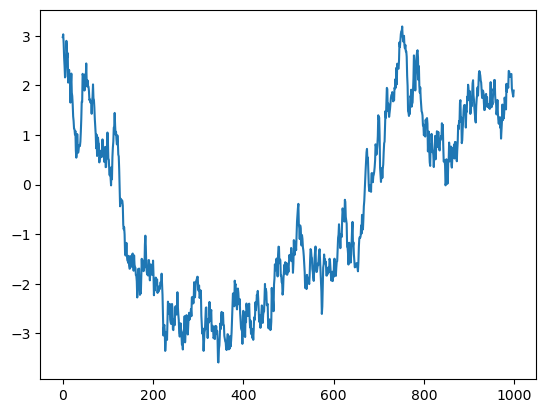

In [31]:
trajectory, target, target_real = simulate_trajectory(batch_size)
print(trajectory[0,:].shape)
plt.plot(trajectory[0,:])

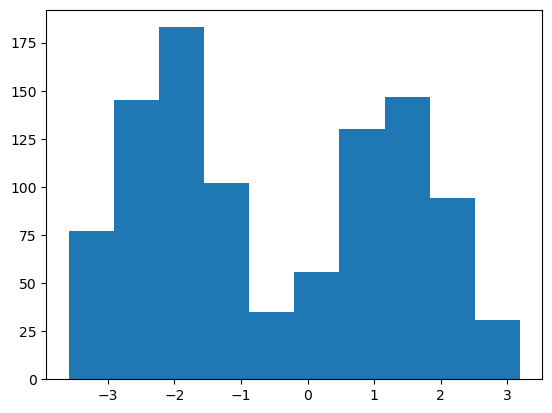

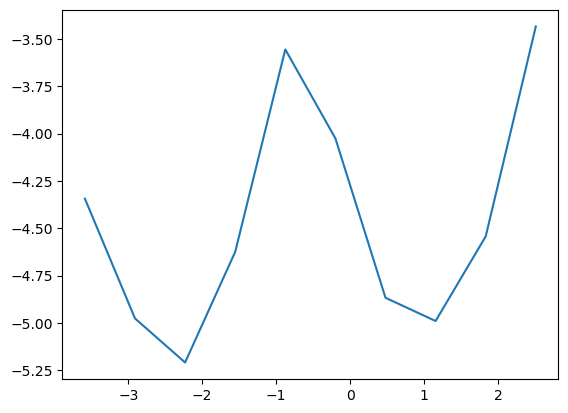

In [32]:
a=plt.hist(trajectory[0])#x[0])
plt.show()
a_1,a_2 = a[0],a[1]

plt.plot(a_2[:-1],-np.log(a_1))
plt.show()

### 4. COMPILE Deep Neural Network

The parameters of the deep learning network are defined and the network created. The summary of the network is printed where the output shape and number of parameters for each layer can be visualized.

Comments:

1. The parameter input_shape determines the shape of the input sequence, given by the number of time-steps times the number of samples in each input sequence. Make sure your input shape dimensions match the length of the input trajectory, in this example 2 x 500 = 1000.
2. The parmameter conv_layers_dimensions determines the number and size of LSTM layers.
3. The parameter number_of_outputs determines the number of outputs, i.e. the number of force field parameters to be estimated.

#### LSTM

CREATE MODEL

In [4]:
from src_models import models_DNN, train_DNN, test_DNN

2023-06-13 00:07:43.746948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
### Define parameters of the deep learning network
input_shape = (None, 50)      
lstm_layers_dimensions = (250, 50)
number_of_outputs = 1

DNN = 'LSTM'
attention = False

### Create deep learning network
network = models_DNN.create_deep_learning_network(input_shape, lstm_layers_dimensions, number_of_outputs, 
                                                      DNN,
                                                      attention)

### Print deep learning network summary
network.summary()

2023-06-13 00:07:49.898323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 00:07:49.899910: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, None, 250)         301000    
                                                                 
 lstm_2 (LSTM)               (None, 50)                60200     
                                                                 
 output (Dense)              (None, 1)                 51        
                                                                 
Total params: 361,251
Trainable params: 361,251
Non-trainable params: 0
_________________________________________________________________


/home/david/anaconda3/envs/firstenv/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### 5. TRAIN Deep Neural Network

The parameters for the training of the deep learning network are defined and the network is trained. The sample size, iteration number, MSE, MAE and the time of each iteration is printed.

Comments:

The parameter sample_sizes determines the sizes of the batches of trajectories used in the training.
The parameter iteration_numbers determines the numbers of batches used in the training.
The parameter verbose determines the frequency of the update messages. It can be either a boolean value (True/False) or a number between 0 and 1.

In [6]:
%%time

sample_sizes = (32, 128, 512)#(32, 128, 512, 2048),
iteration_numbers = (3001, 2001, 1001)#(1001, 2001, 3001),#(3001, 2001, 1001, 101),
verbose = .1

training_history = train_DNN.train_deep_learning_network(network, simulate_trajectory, sample_sizes, iteration_numbers, verbose)

Sample size     32   iteration number      1   MSE     3.0866   MAE     1.4896   Time 8138.593435 ms
Sample size     32   iteration number     11   MSE     1.4111   MAE     0.8050   Time 882.719278 ms
Sample size     32   iteration number     21   MSE     0.3801   MAE     0.4937   Time 617.191792 ms
Sample size     32   iteration number     31   MSE     0.3571   MAE     0.4789   Time 1008.936167 ms
Sample size     32   iteration number     41   MSE     0.2694   MAE     0.4439   Time 1102.082968 ms
Sample size     32   iteration number     51   MSE     0.1608   MAE     0.3312   Time 1099.079132 ms
Sample size     32   iteration number     61   MSE     0.0958   MAE     0.2450   Time 1279.945850 ms
Sample size     32   iteration number     71   MSE     0.1131   MAE     0.2400   Time 854.305983 ms
Sample size     32   iteration number     81   MSE     0.1548   MAE     0.2944   Time 1071.509838 ms
Sample size     32   iteration number     91   MSE     0.1320   MAE     0.3050   Time 844.3329

### 6. TEST MODEL

In [7]:
%%time

number_of_predictions_to_show = 1000
prediction_test = test_DNN.test_performance(simulate_trajectory, network, rescale_targets, number_of_predictions_to_show)

1/1 [==============================] - 0s 64ms/step
CPU times: user 3min 57s, sys: 8min 11s, total: 12min 8s
Wall time: 3min 16s


### 7. Store Training and Predicted history

In [8]:
import pickle
def save_data(a, name):
    with open('{}.pkl'.format(name), 'wb') as f:
        pickle.dump(a, f) #, protocol=pickle.HIGHEST_PROTOCOL)
    # close file
    f.close()

#from datetime import datetime
#date = datetime.today().strftime('%Y-%m-%d')

## file name
name_train = 'training_history_{}_{}'.format(DNN, case_study)
name_pred = 'prediction_{}_test_{}'.format(DNN, case_study)

if normal_values == False:
    name_train = name_train + '_B'
    name_pred = name_pred + '_B'
if attention == True:
    name_train = name_train + '_attention'
    name_pred = name_pred + '_attention' 

# save train data
save_data(training_history, name_train)
# save test data
save_data(prediction_test, name_pred)

#load
#with open('filename.pickle', 'rb') as handle:
#    b = pickle.load(handle)

### 8. Plot results

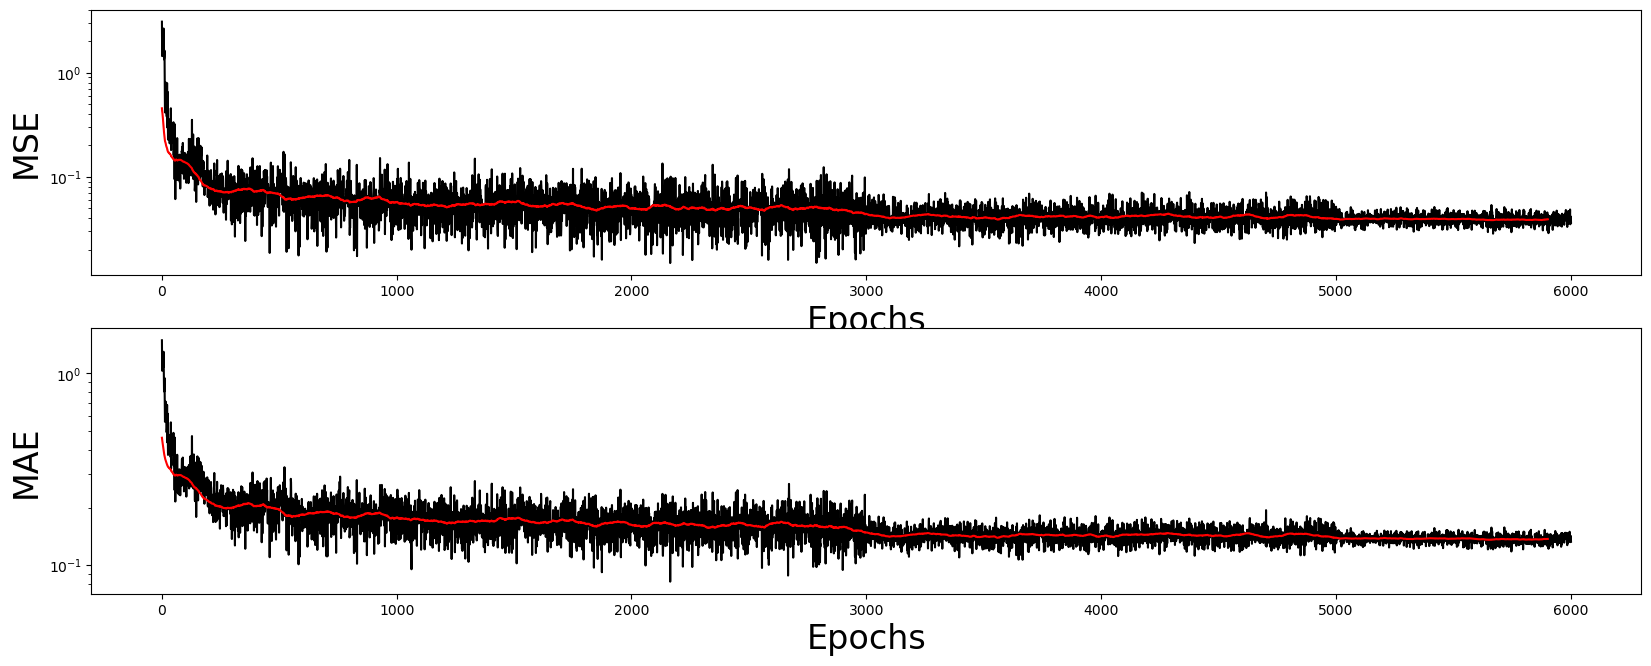

In [9]:
### Plot learning performance
number_of_timesteps_for_average = 100
train_DNN.plot_learning_performance(training_history, number_of_timesteps_for_average)

In [10]:
# average MSE and MAE
avg_mae= round(sum(training_history["MAE"])/len(training_history["MAE"]), 5)
avg_mse=round(sum(training_history["MSE"])/len(training_history["MSE"]), 5)
print('MSE: ',avg_mae)
print('MAE: ',avg_mae)

MSE:  0.16447
MAE:  0.16447


In [ ]:
### Plot test performance
#test_DNN.plot_test_performance(prediction_test[0], prediction_test[1], prediction_test[2], prediction_test[3], network)